In [ ]:
# Config Parameters for the model
# Set the batch size here
# increase for systems with more memory, 32 should be enough for most systems
BATCH_SIZE = 32

## Part 1: Unpack our data
All we do is install 7zip and then use pyunpack to extract the files. This saves datasets to /notebooks which is a directory on Paperspace Gradient that is acceptable by python.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

import zipfile

# dataset file name
data_file = "data_2" # change this to your dataset file name

zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/data_2.zip", 'r')
zip_ref.extractall()
zip_ref.close()

data_dir = '/content/' + data_file + '/'
train_dir = data_dir + 'train/' # directory for training images
test_dir = data_dir + 'test/' # directory for test images we use the test images to make sure our model is working well

Mounted at /content/gdrive


## Part 3: Loading in the data
### Dealing with images
Our image files are quite large, and attempting to load them all into memory at once would likely cause your computer to crash. To circumvent this, we're taking a more efficient approach: we only store the file paths (where the images are located) initially. Later, we'll implement a system to automatically load these images only when they are needed during the training process.

A key piece of information is the naming convention: each image is named (somenumber).jpg, where the number represents the milliseconds since January 1, 1970 (Unix Time) when the image was recorded. This unique, time-based naming guarantees that we won't have any overlapping file names.

Since the images are named by time, we must sort the file paths from the smallest time (oldest) to the largest time (newest). This chronological sorting is absolutely crucial to make sure they align correctly with the sequentially recorded steering angles.

### Dealing with steering angles
In contrast to the images, our steering values are stored in a CSV file. Since these are just numerical values, they take up very little RAM. We can safely load all the steering values into a list at once using Python's built-in csv module.

### Making sure the files line up
Since we sort our images, and the csv file is read in line by line the files will line up with their correct steering angles. It looks something like this. If we mess this up then the data being fed into your network would be totally incoherent. Garbage in Garbage out.

train_img =   | image 1    | image 2    | image 3    | image 4    | image 5    |...

train_steer = | steering 1 | steering 2 | steering 3 | steering 4 | steering 5 |...

In [ ]:
import csv
import os
# lets make a function that loads the images and labels
def load_data(directory):
    image__paths = []
    for file in os.listdir(directory): # for each file in the directory
        if file.endswith(".png"): # if the file is an image
            image__paths.append(directory + file) # add the image path to the list
    print(image__paths)
    # now our files are in the train list we need to sort them from smallest file name to largest. The file name is the exact time the image was taken.
    image__paths.sort(key=lambda x: int(x.split('/')[-1][:-4].split('_')[0][:])) # the lambda function returns the numbers in the file name
    print(image__paths)
    # now we get the steering angles
    steering_angles = [] # create a list to store the steering angles
    for angle in image__paths: # for each row in the csv file
        steering_angles.append(float(angle.split('/')[-1][:-4].split('_')[-1].replace('-','.'))) # add the steering angle to the list
    print(steering_angles)
    return image__paths, steering_angles # return the image paths and steering angles

# We call our load data function to get the image paths and steering angles
train_img, train_steer = load_data(train_dir) # load the training data
test_img, test_steer = load_data(test_dir) # load the test data





['/content/data_2/train/2734_91-323.png', '/content/data_2/train/1875_115-05.png', '/content/data_2/train/3661_94-726.png', '/content/data_2/train/475_90-717.png', '/content/data_2/train/4815_102-997.png', '/content/data_2/train/1728_108-854.png', '/content/data_2/train/1097_80-734.png', '/content/data_2/train/3678_98-415.png', '/content/data_2/train/1298_77-728.png', '/content/data_2/train/210_90-008.png', '/content/data_2/train/4095_94-967.png', '/content/data_2/train/255_143-481.png', '/content/data_2/train/121_79-169.png', '/content/data_2/train/474_90-776.png', '/content/data_2/train/4583_80-053.png', '/content/data_2/train/2514_59-728.png', '/content/data_2/train/4260_15.png', '/content/data_2/train/3166_110-078.png', '/content/data_2/train/1789_121-129.png', '/content/data_2/train/3259_94-499.png', '/content/data_2/train/1079_86-536.png', '/content/data_2/train/2905_104-546.png', '/content/data_2/train/3368_88-066.png', '/content/data_2/train/456_92-072.png', '/content/data_2/tr

## Part 4: Loading in the images

### Dataset Creation
The dataset creation involves the creation of what is known as a dataset pipeline. All this is, is a sequence of transformations applied one after the other that manipulate the data in different ways.
1. from_tensor_slices. We load in the images and the steering angles into the dataset
2. repeat. Simply loop the dataset for infinity when we get to the end. This is done to make sure our network never runs out of data. For instance we train on batches of 32 if we had 52 images we would run out of data.
3. shuffle. Self explanatory makes sure we don't feed network ordered data as this can cause weird issues. Note we don't need to do this with our validation data so we might as well save the unnecessary operation by excluding shuffle.
4. batch. Tell the dataset that when we fetch a item from it is should return a number of items. This is more efficient as you almost certainly have enough RAM to handle more than 1 image.
5. Prefetch. Tell the dataset that when it's not doing anything it should automatically be loading data into RAM in the background. This results in huge performance increases as when we're training we don't have to sit around waiting for the dataset to load the images.




Loading training data


100%|██████████| 5000/5000 [00:01<00:00, 2726.38it/s]


Loading test data


100%|██████████| 3000/3000 [00:00<00:00, 4053.44it/s]


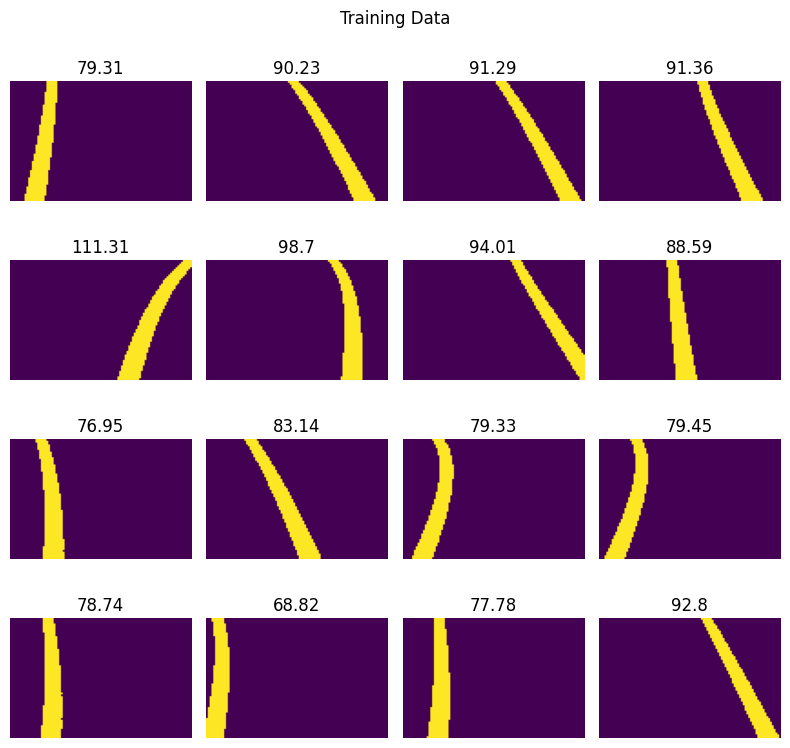

In [ ]:
import matplotlib.pyplot as plt # import matplotlib for plotting
import tensorflow as tf
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import tqdm

train_data = []
test_data = []

tqdm.tqdm.write("Loading training data")
# load the images and steering angles into numpy arrays
for path in tqdm.tqdm(train_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    train_data.append(array)

tqdm.tqdm.write("Loading test data")
# loading the testing data
for path in tqdm.tqdm(test_img):
    img = cv.imread(path) # read the image
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # mask the image to get only the desired colors
    mask = cv.inRange(hsv, (36, 0, 0), (70, 255,255))
    array = np.array(mask, dtype=np.float32)
    test_data.append(array)

# create a dataset from the training data and make a data pipeline
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_steer)) # create a dataset from the image paths and steering angles
train_ds = train_ds.repeat()
train_ds = train_ds.shuffle(buffer_size=len(train_img)) # shuffle the dataset
train_ds = train_ds.batch(BATCH_SIZE) # batch the dataset
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# create a dataset from the testing data and make a data pipeline
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_steer)) # create a dataset from the image paths and steering angles
test_ds = test_ds.repeat() # repeat the dataset
test_ds = test_ds.batch(BATCH_SIZE) # batch the dataset
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE) # prefetch the dataset to improve performance

# output the first 16 images and steering angles from the dataset
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(train_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
plt.tight_layout()
plt.show()

## Part 5: Creating the model
This CNN model is modified for a low Mean Squared Error (MSE) score by maximizing its capacity to learn complex patterns in the images. The architecture is split into two main parts: a feature extractor and a deep regressor.

The feature extractor uses two pairs of Conv2D and MaxPool2D layers. It starts with 36 filters and increases to 72 filters in the second layer, allowing the model to detect a greater number of increasingly complex visual features (like edges, shadows, and road markings) crucial for steering. The MaxPool2D layers aggressively down-sample the features, making the model translationally robust—meaning it can still recognize a feature even if it shifts slightly in the image—which is vital for real-world driving.

The subsequent deep regression head is highly unusual and designed for extreme complexity, featuring multiple Dense layers, including two very large layers with 1200 nodes each. This large number of parameters gives the network immense capacity to model the highly non-linear relationship between the extracted visual features and the final steering angle. The final output is a single node with a linear activation, which is the correct setup for a regression task like predicting a continuous steering angle. The model is optimized using the Adam optimizer and specifically trained to minimize MSE, which heavily penalizes large errors, forcing the model to achieve high precision.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (32, 63, 97, 36)            │             612 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 15, 24, 36)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 12, 21, 72)            │          41,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 3, 5, 72)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (32, 1080)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (32, 56)                    │          60,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (32, 1200)                  │          68,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (32, 1)                     │           1,201 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (32, 1200)                  │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (32, 48)                    │          57,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (32, 24)                    │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (32, 1)                     │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,542 (912.27 KB)

 Trainable params: 233,542 (912.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 4114.4082 - val_loss: 45.0847
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 46.8899 - val_loss: 6.2223
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0403 - val_loss: 8.4178
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9167 - val_loss: 4.6116
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6048 - val_loss: 4.7005
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5225 - val_loss: 3.9987
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0105 - val_loss: 4.2433
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7223 - val_loss: 5.5478
Epoch 9/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3728 - val_loss: 3.5359
Epoch 10/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0597 - val_loss: 5.1204
Epoch 11/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1880 - val_loss: 4.0211
Epoch 12/50
156/156 ━━━━━━━━━━━━━━━━━━━━

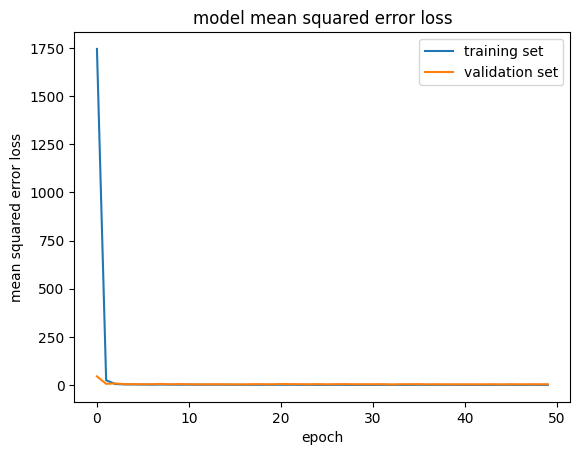

In [ ]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Conv2D, Flatten, MaxPool2D, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# a sequential model is a model that is made up of layers
model = Sequential()
# the input layer is the first layer in the model. You shouldn't need to change this.
model.add(InputLayer(input_shape=(66, 100, 1), batch_size=BATCH_SIZE))

# try modifying the number of nodes in the hidden layer to see how it affects the model
# you can also try changing the activation function to see how it affects the model
# adding more layers to the model may also help you to acheive your score

# in this lab you also have access to the Conv2D layer and MaxPool2D layer. Try modifying these to see how they affect the model.
model.add(Conv2D(36, (4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(72, (4,4), activation='relu'))
model.add(MaxPool2D(pool_size=(4,4)))

model.add(Flatten())  # flatten layer
model.add(Dense(56, activation='relu'))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dense(1, activation='linear'))
model.add(Dense(1200, activation='sigmoid'))
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='linear'))

optimizer = Adam(learning_rate=0.001)  # try changing the learning rate to see how it affects the model
model.compile(optimizer=optimizer, loss='mse')  # we will keep track of the mean squared error

print(model.summary())  # print a summary of the model

# Train the model without EarlyStopping
epoch = 50
hist = model.fit(train_ds,
                 steps_per_epoch=len(train_img) // BATCH_SIZE,
                 validation_data=test_ds,
                 validation_steps=len(test_img) // BATCH_SIZE,
                 epochs=epoch)  # EarlyStopping removed

# let's plot the model's history
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.plot(np.log(hist.history['loss']))       # log scale
# plt.plot(np.log(hist.history['val_loss']))   # log scale
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()


The graph above displays the model's performance by tracking the Mean Squared Error (MSE) loss over 50 training epochs. It shows a dramatic initial improvement, where both the training loss (blue line) and validation loss (orange line) drop sharply from very high values within the first few epochs as the model quickly learns. After this initial convergence, both loss curves flatten out and remain very low and stable. The fact that the training loss is consistently slightly below the validation loss indicates a small degree of overfitting, meaning the model performs marginally better on the data it has seen than on unseen data. Overall, the model has successfully converged to a point of good performance and generalization, as the validation loss is very low and does not increase.

## Part 6: Test the model
We'll now output 16 images with the predicted steering angles along with the actual steering angles

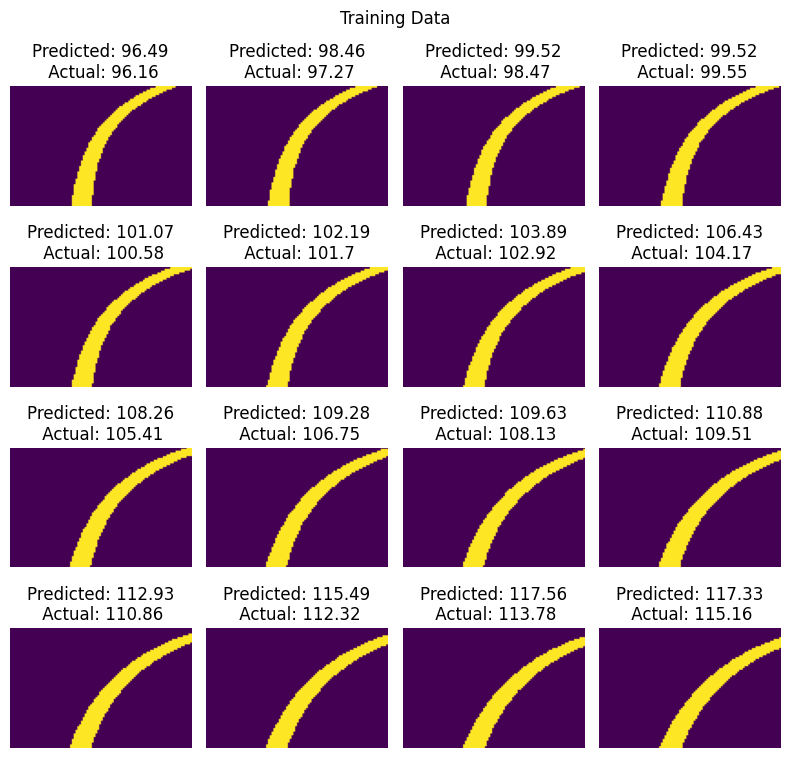

In [ ]:
# output the first 16 images and steering angles from the test dataset then predict the steering angle for the images
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
# add title to the figure
fig.suptitle('Training Data')
fig.tight_layout()

imgs, steer = next(iter(test_ds)) # get the first batch of images and steering angles

for i in range(16):
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].imshow(imgs[i])
    axs[i//4, i%4].set_title(round(steer[i].numpy(), 2))
    predicted = model(imgs[i].numpy().reshape(1, 66, 100, 1)) # predict the steering angle for the image
    axs[i//4, i%4].set_title("Predicted: " + str(np.round(predicted[0][0].numpy(), 2)) + "\n Actual: " + str(round(steer[i].numpy(), 2)))
plt.tight_layout()
plt.show()

In [ ]:
!pip install onnx
!pip install tf2onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import onnx
import tf2onnx
import tensorflow as tf

model_name = "conv_model" # change the name to something more descriptive if you want
model.save(model_name + '.keras')
model.save(model_name + ".h5")
model.output_names = ['output']
input_signature = [tf.TensorSpec([None, 66, 100, 1], tf.float32, name='input')]

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature, opset=13)

onnx.save(onnx_model, model_name + ".onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c8642b26200>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
